In [24]:
from time import time
import networkx as nx
import pickle
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import torch
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader
import torch.utils.data as Data
import numpy as np
%matplotlib inline
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class args(object):
    
    #### DATA  ####
    node_size = 21 # equals to the number of nodes + 1 (zero_padding)
    seq_len = 5
    
    #### Training ####
    batch_size = 32
    lr = 0.0002
    beta1 = 0.9
    beta2 = 0.999
    LSTM_maxnorm = 0.25
    acc_threshold = 0.5
    try_valid = 20
    running_loss = True
    n_epoch = 50
    weight_reg = 0
    
    
    #### Model ####
    hidden_size = 50
    num_layers = 2
    embedding_dim = 50
    embedding_maxnorm = None
    bidirectional_LSTM = False 
    model_name = 'Siamese' 
    model_path ='./'+ model_name +'/Model/'
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

'''
TODO:

1. Add GRU
2. Add Algo
'''   

with open("Planar10thData.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    
del df

#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 64)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size= 0.05,random_state= 64)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

def padding(data):
    left = [] 
    for i in range(data.shape[0]):
        left.append((data.iloc[i]['left']))
    right = [] 
    for i in range(data.shape[0]):
        right.append((data.iloc[i]['right']))
    return torch.tensor(np.array([right,left])).transpose(1,0)


def plot_train_hist(train_hist, step = None):
    fig = plt.figure(figsize=(20, 10))
    for name in train_hist.keys():
        if 'Loss' in name:
            plt.subplot(211)
            plt.plot(train_hist[name],marker='o',label= name)
            plt.ylabel('Loss',fontsize=15)
            plt.xlabel('Number of epochs',fontsize=15)
            plt.title('Loss',fontsize=20,fontweight ="bold")
            plt.legend(loc='upper left')
        else:
            plt.subplot(212)
            plt.plot(train_hist[name],marker='o',label= name)
            plt.ylabel('Accuracy',fontsize=15)
            plt.xlabel('Number of epochs',fontsize=15)
            plt.title('Accuracy',fontsize=20,fontweight ="bold")
            plt.legend(loc='upper left')
        
    plt.tight_layout()
    plt.show()
    if step is not None:
        fig.savefig("Train_Hist"+str(step)+".png") 


#Padding and creat the loaders
X_train = padding(X_train)
Y_train = torch.FloatTensor(np.array(Y_train))
train_dataset  = Data.TensorDataset(X_train,Y_train)

X_validation = padding(X_validation)
Y_validation = torch.FloatTensor(np.array(Y_validation))
val_dataset  = Data.TensorDataset(X_validation,Y_validation)

X_test = padding(X_test)
Y_test = torch.FloatTensor(np.array(Y_test))
test_dataset  = Data.TensorDataset(X_test,Y_test)


In [4]:
X_validation.shape

torch.Size([800, 2, 5])

In [5]:
class LSTM_Encoder(nn.Module):
    def __init__(self,):
        super(LSTM_Encoder, self).__init__()
        
        # No need for padding, but if we need the padding, we have to set the idx as 0
        # So that's why we need to make the graph start from 0
        
        self.embedding = nn.Embedding(args.node_size, embedding_dim = args.embedding_dim, padding_idx=0,
                                      max_norm = args.embedding_maxnorm)
        self.lstm = nn.LSTM(input_size = args.embedding_dim, hidden_size = args.hidden_size,
                           num_layers = args.num_layers, bidirectional = args.bidirectional_LSTM, batch_first = True)

        if args.bidirectional_LSTM:
            num_dir = 2
            fc_size1= args.hidden_size*args.seq_len*2
            fc_size2= 128
        else:
            num_dir = 1
            fc_size1= args.hidden_size
            fc_size2= 16
            
        self.fc= nn.Sequential(
            nn.Linear(fc_size1,fc_size2),
            nn.BatchNorm1d(fc_size2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(fc_size2,2),
        )
        
        self.h0 = nn.Parameter(torch.randn(args.num_layers*num_dir, 1, args.hidden_size))
        self.c0 = nn.Parameter(torch.ones(args.num_layers*num_dir, 1, args.hidden_size))
        
    def forward(self, x):
        
        B = x.size(0)
        
        out = self.embedding(x)
        out, (hidden, cell) = self.lstm(out, (self.h0.repeat(1,B,1), self.c0.repeat(1,B,1)))
        
        if args.bidirectional_LSTM:
            out = self.fc(out.contiguous().view(B,-1))
        else:
            out = self.fc(out[:,-1,:])
        return out
    
    

class SiameseNet(nn.Module):
    def __init__(self,):
        super(SiameseNet, self).__init__()
        
        self.encoder = LSTM_Encoder()
        self.mse = nn.MSELoss()
        self.train_hist = defaultdict(list)
        self.acc_hist = []
        self.apply(self.weight_init)
        
        self.optim = optim.Adam(self.encoder.parameters(), lr = args.lr, betas= (args.beta1, args.beta2),
                                weight_decay = args.weight_reg)
        
        
    def forward(self, x, y):
        
        self.optim.zero_grad()
        left = x[:,0,:]
        right = x[:,1,:]
        
        left_out = self.encoder(left)
        right_out = self.encoder(right)
        self.prediction = torch.exp(-torch.norm((left_out - right_out),1,-1))
        self.loss = self.mse(self.prediction, y)
        self.take = left_out - right_out
        
        if args.LSTM_maxnorm is not None:
            nn.utils.clip_grad_norm_(self.encoder.lstm.parameters(), args.LSTM_maxnorm)
        self.acc = torch.mean(((self.prediction>args.acc_threshold) == (y.byte())).float())
        self.train_hist['Loss'].append(self.loss.item())
        self.train_hist['Accuracy'].append(self.acc.item())
        self.loss.backward()
        self.optim.step()
        
    def weight_init(self,m):
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()
                    
    def model_save(self,step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name:self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
           
    def plot_all_loss(self, step):
        fig = plt.figure(figsize=(20, 10))
        num_loss = 2
        i = 0
        for name in self.train_hist.keys():
            if 'V' not in name:
                i+= 1
                fig.add_subplot(num_loss,1,i)
                plt.plot(self.train_hist[name], label = name)
                plt.xlabel('Number of Steps',fontsize=15)
                plt.ylabel( name, fontsize=15)
                plt.title(name, fontsize=30, fontweight ="bold")
                plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png") 
        
    def test_step(self, x, y):
        
        left = x[:,0,:]
        right = x[:,0,:]
        
        left_out = self.encoder(left)
        right_out = self.encoder(right)
        
        self.v_prediction = torch.exp(-torch.norm((left_out - right_out),1,-1)).detach()
        self.v_loss = self.mse(self.v_prediction, y)
        self.v_acc = torch.mean(((self.v_prediction>args.acc_threshold) == (y.byte())).float())
        self.train_hist['V_Loss'].append(self.v_loss.item())
        self.train_hist['V_Accuracy'].append(self.v_acc.item())    

In [6]:
train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size = args.batch_size, shuffle=True, drop_last= True)

In [7]:
args.weight_reg = 0
siamese = SiameseNet().to(device)
siamese.train()
scheduler = optim.lr_scheduler.MultiStepLR(siamese.optim, milestones=[20,40,60,80], gamma=0.5)
siamese.optim.param_groups[0]['lr']= 0.0002

In [8]:
train_hist = defaultdict(list)
args.running_loss = True
args.n_epoch = 50
all_step = 0
epoch = 0

| Epoch [2] | Step [1347] | lr [0.000200] | Loss: [0.1235] | Acc: [0.8125] | Time: 0.0s
| Epoch [2] | Step [1348] | lr [0.000200] | Loss: [0.1521] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1349] | lr [0.000200] | Loss: [0.1051] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1350] | lr [0.000200] | Loss: [0.0990] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1351] | lr [0.000200] | Loss: [0.1179] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1352] | lr [0.000200] | Loss: [0.1155] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1353] | lr [0.000200] | Loss: [0.0801] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1354] | lr [0.000200] | Loss: [0.1070] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1355] | lr [0.000200] | Loss: [0.0864] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1356] | lr [0.000200] | Loss: [0.0947] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1357] | lr [0.000200] | Loss: [0.1123] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1358] | lr [

| Epoch [2] | Step [1442] | lr [0.000200] | Loss: [0.1133] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1443] | lr [0.000200] | Loss: [0.0866] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1444] | lr [0.000200] | Loss: [0.1132] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1445] | lr [0.000200] | Loss: [0.1031] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1446] | lr [0.000200] | Loss: [0.1396] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1447] | lr [0.000200] | Loss: [0.1120] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1448] | lr [0.000200] | Loss: [0.1083] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1449] | lr [0.000200] | Loss: [0.1251] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1450] | lr [0.000200] | Loss: [0.0679] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1451] | lr [0.000200] | Loss: [0.1119] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1452] | lr [0.000200] | Loss: [0.1054] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1453] | lr [

| Epoch [2] | Step [1542] | lr [0.000200] | Loss: [0.1558] | Acc: [0.7812] | Time: 0.0s
| Epoch [2] | Step [1543] | lr [0.000200] | Loss: [0.0928] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1544] | lr [0.000200] | Loss: [0.0936] | Acc: [0.9688] | Time: 0.0s
| Epoch [2] | Step [1545] | lr [0.000200] | Loss: [0.1404] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1546] | lr [0.000200] | Loss: [0.0980] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1547] | lr [0.000200] | Loss: [0.0740] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1548] | lr [0.000200] | Loss: [0.0836] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1549] | lr [0.000200] | Loss: [0.1388] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1550] | lr [0.000200] | Loss: [0.1071] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1551] | lr [0.000200] | Loss: [0.1190] | Acc: [0.8125] | Time: 0.0s
| Epoch [2] | Step [1552] | lr [0.000200] | Loss: [0.1418] | Acc: [0.7500] | Time: 0.0s
| Epoch [2] | Step [1553] | lr [

| Epoch [2] | Step [1638] | lr [0.000200] | Loss: [0.1077] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1639] | lr [0.000200] | Loss: [0.1466] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1640] | lr [0.000200] | Loss: [0.0651] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1641] | lr [0.000200] | Loss: [0.0985] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1642] | lr [0.000200] | Loss: [0.1240] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1643] | lr [0.000200] | Loss: [0.1074] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1644] | lr [0.000200] | Loss: [0.1032] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1645] | lr [0.000200] | Loss: [0.1296] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1646] | lr [0.000200] | Loss: [0.1183] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1647] | lr [0.000200] | Loss: [0.0963] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1648] | lr [0.000200] | Loss: [0.0949] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1649] | lr [

| Epoch [2] | Step [1738] | lr [0.000200] | Loss: [0.0939] | Acc: [0.9375] | Time: 0.0s
| Epoch [2] | Step [1739] | lr [0.000200] | Loss: [0.0477] | Acc: [0.9688] | Time: 0.0s
| Epoch [2] | Step [1740] | lr [0.000200] | Loss: [0.0873] | Acc: [0.9688] | Time: 0.0s
| Epoch [2] | Step [1741] | lr [0.000200] | Loss: [0.0995] | Acc: [0.8750] | Time: 0.0s
| Epoch [2] | Step [1742] | lr [0.000200] | Loss: [0.0915] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1743] | lr [0.000200] | Loss: [0.0833] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1744] | lr [0.000200] | Loss: [0.0919] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1745] | lr [0.000200] | Loss: [0.1210] | Acc: [0.8438] | Time: 0.0s
| Epoch [2] | Step [1746] | lr [0.000200] | Loss: [0.0848] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1747] | lr [0.000200] | Loss: [0.0860] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1748] | lr [0.000200] | Loss: [0.1069] | Acc: [0.9062] | Time: 0.0s
| Epoch [2] | Step [1749] | lr [

| Epoch [2] | Validation | Step [16] |  Loss: [0.5938] | Acc: [0.4062] | Time: 0.0s
| Epoch [2] | Validation | Step [17] |  Loss: [0.4688] | Acc: [0.5312] | Time: 0.0s
| Epoch [2] | Validation | Step [18] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [2] | Validation | Step [19] |  Loss: [0.6562] | Acc: [0.3438] | Time: 0.0s
| Epoch [2] | Validation | Step [20] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [2] | Validation | Step [21] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s
| Epoch [2] | Validation | Step [22] |  Loss: [0.4375] | Acc: [0.5625] | Time: 0.0s
| Epoch [2] | Validation | Step [23] |  Loss: [0.5312] | Acc: [0.4688] | Time: 0.0s
| Epoch [2] | Validation | Step [24] |  Loss: [0.5625] | Acc: [0.4375] | Time: 0.0s


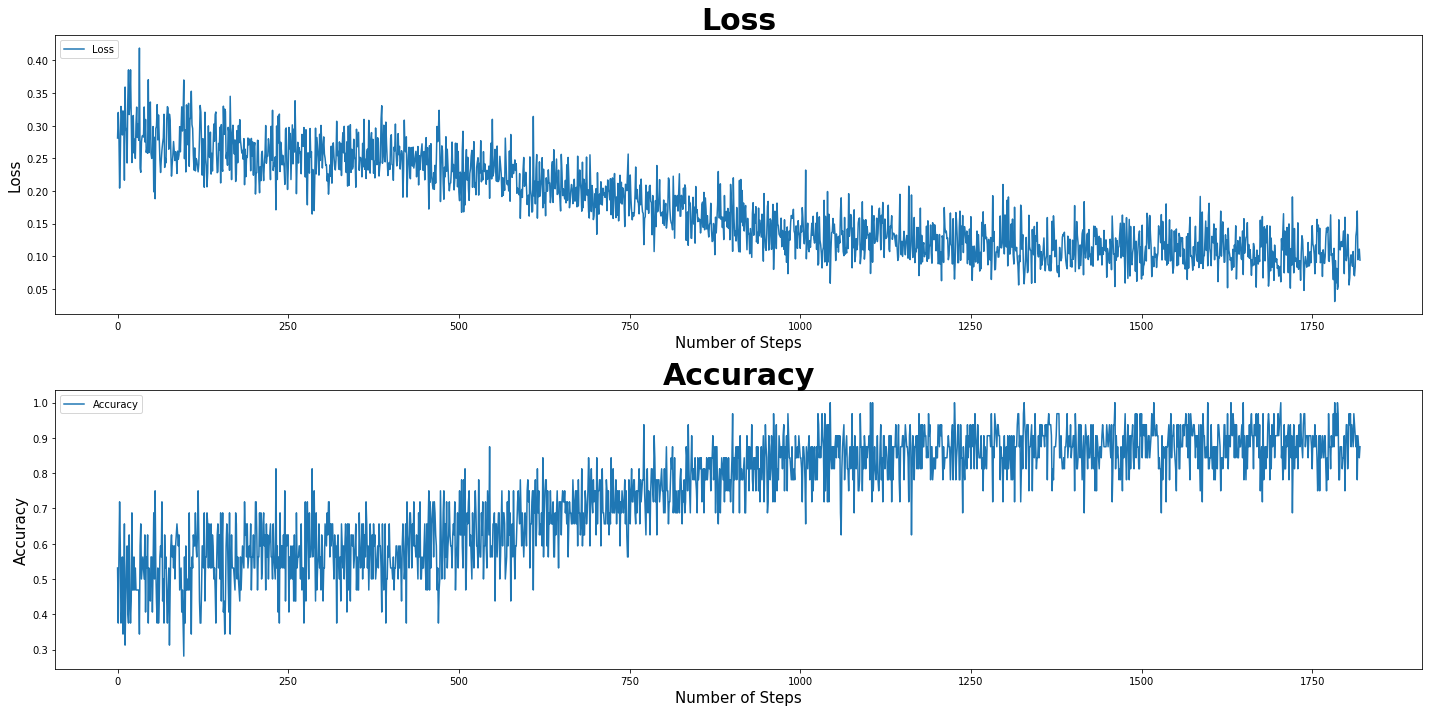

/Users/richard/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


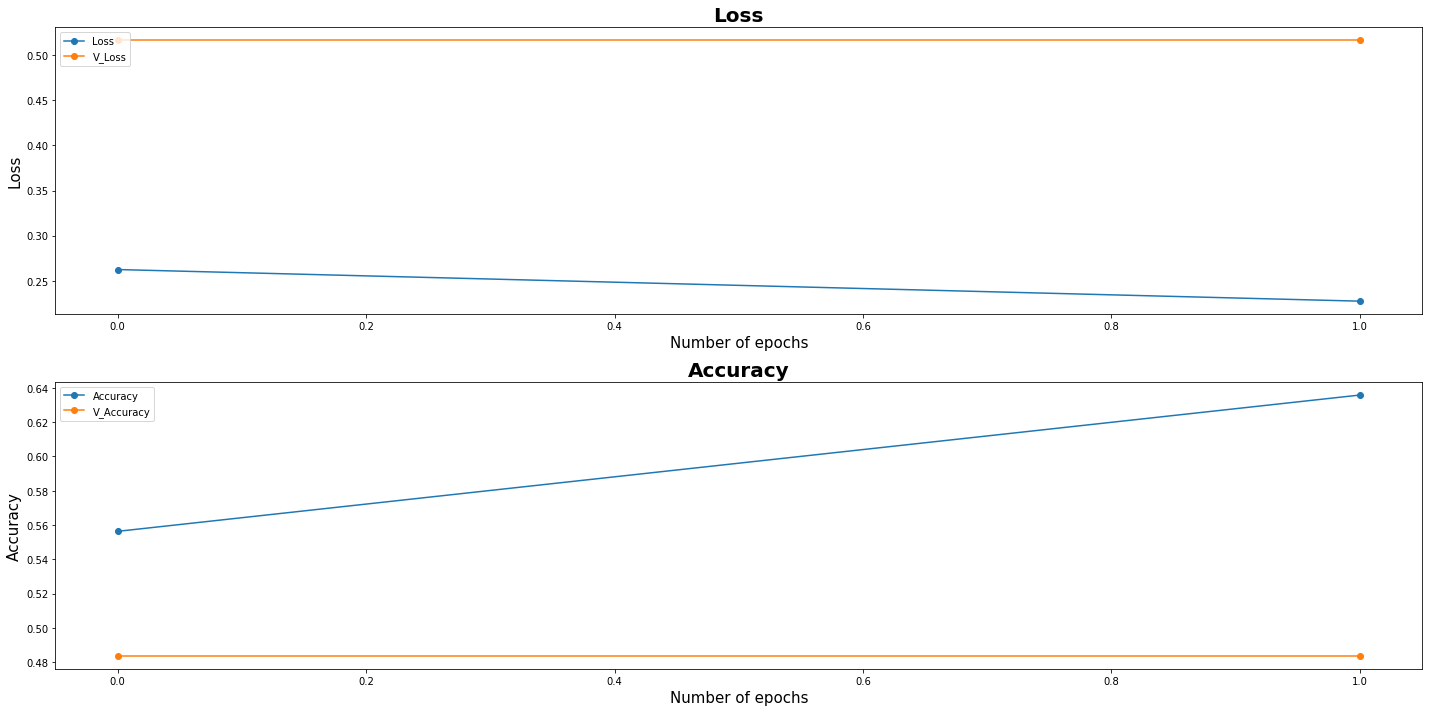

Model Saved
| Epoch [3] | Step [1822] | lr [0.000200] | Loss: [0.1365] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [1823] | lr [0.000200] | Loss: [0.1405] | Acc: [0.8125] | Time: 0.0s
| Epoch [3] | Step [1824] | lr [0.000200] | Loss: [0.1330] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [1825] | lr [0.000200] | Loss: [0.1094] | Acc: [0.8438] | Time: 0.0s
| Epoch [3] | Step [1826] | lr [0.000200] | Loss: [0.0873] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [1827] | lr [0.000200] | Loss: [0.1088] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1828] | lr [0.000200] | Loss: [0.0840] | Acc: [0.9688] | Time: 0.0s
| Epoch [3] | Step [1829] | lr [0.000200] | Loss: [0.1185] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [1830] | lr [0.000200] | Loss: [0.1116] | Acc: [0.8438] | Time: 0.0s
| Epoch [3] | Step [1831] | lr [0.000200] | Loss: [0.0845] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1832] | lr [0.000200] | Loss: [0.0664] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [

| Epoch [3] | Step [1924] | lr [0.000200] | Loss: [0.1257] | Acc: [0.8438] | Time: 0.0s
| Epoch [3] | Step [1925] | lr [0.000200] | Loss: [0.0627] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [1926] | lr [0.000200] | Loss: [0.1128] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [1927] | lr [0.000200] | Loss: [0.1099] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1928] | lr [0.000200] | Loss: [0.0886] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1929] | lr [0.000200] | Loss: [0.1183] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [1930] | lr [0.000200] | Loss: [0.1019] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1931] | lr [0.000200] | Loss: [0.0797] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1932] | lr [0.000200] | Loss: [0.1280] | Acc: [0.8125] | Time: 0.0s
| Epoch [3] | Step [1933] | lr [0.000200] | Loss: [0.1024] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1934] | lr [0.000200] | Loss: [0.0963] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [1935] | lr [

| Epoch [3] | Step [2029] | lr [0.000200] | Loss: [0.0761] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2030] | lr [0.000200] | Loss: [0.0785] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2031] | lr [0.000200] | Loss: [0.0871] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [2032] | lr [0.000200] | Loss: [0.0894] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2033] | lr [0.000200] | Loss: [0.1121] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2034] | lr [0.000200] | Loss: [0.0911] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2035] | lr [0.000200] | Loss: [0.0955] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2036] | lr [0.000200] | Loss: [0.0756] | Acc: [0.9688] | Time: 0.0s
| Epoch [3] | Step [2037] | lr [0.000200] | Loss: [0.1619] | Acc: [0.8125] | Time: 0.0s
| Epoch [3] | Step [2038] | lr [0.000200] | Loss: [0.1118] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2039] | lr [0.000200] | Loss: [0.0496] | Acc: [0.9688] | Time: 0.0s
| Epoch [3] | Step [2040] | lr [

| Epoch [3] | Step [2126] | lr [0.000200] | Loss: [0.0910] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2127] | lr [0.000200] | Loss: [0.1208] | Acc: [0.8438] | Time: 0.0s
| Epoch [3] | Step [2128] | lr [0.000200] | Loss: [0.0796] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2129] | lr [0.000200] | Loss: [0.0963] | Acc: [0.8750] | Time: 0.0s
| Epoch [3] | Step [2130] | lr [0.000200] | Loss: [0.0888] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2131] | lr [0.000200] | Loss: [0.1065] | Acc: [0.8125] | Time: 0.0s
| Epoch [3] | Step [2132] | lr [0.000200] | Loss: [0.0670] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2133] | lr [0.000200] | Loss: [0.0870] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2134] | lr [0.000200] | Loss: [0.0751] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2135] | lr [0.000200] | Loss: [0.0709] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2136] | lr [0.000200] | Loss: [0.1525] | Acc: [0.8125] | Time: 0.0s
| Epoch [3] | Step [2137] | lr [

| Epoch [3] | Step [2231] | lr [0.000200] | Loss: [0.1229] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2232] | lr [0.000200] | Loss: [0.1102] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2233] | lr [0.000200] | Loss: [0.1003] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2234] | lr [0.000200] | Loss: [0.1017] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2235] | lr [0.000200] | Loss: [0.0878] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2236] | lr [0.000200] | Loss: [0.1128] | Acc: [0.8438] | Time: 0.0s
| Epoch [3] | Step [2237] | lr [0.000200] | Loss: [0.0950] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2238] | lr [0.000200] | Loss: [0.0785] | Acc: [0.9062] | Time: 0.0s
| Epoch [3] | Step [2239] | lr [0.000200] | Loss: [0.1698] | Acc: [0.7812] | Time: 0.0s
| Epoch [3] | Step [2240] | lr [0.000200] | Loss: [0.0806] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2241] | lr [0.000200] | Loss: [0.1035] | Acc: [0.9375] | Time: 0.0s
| Epoch [3] | Step [2242] | lr [

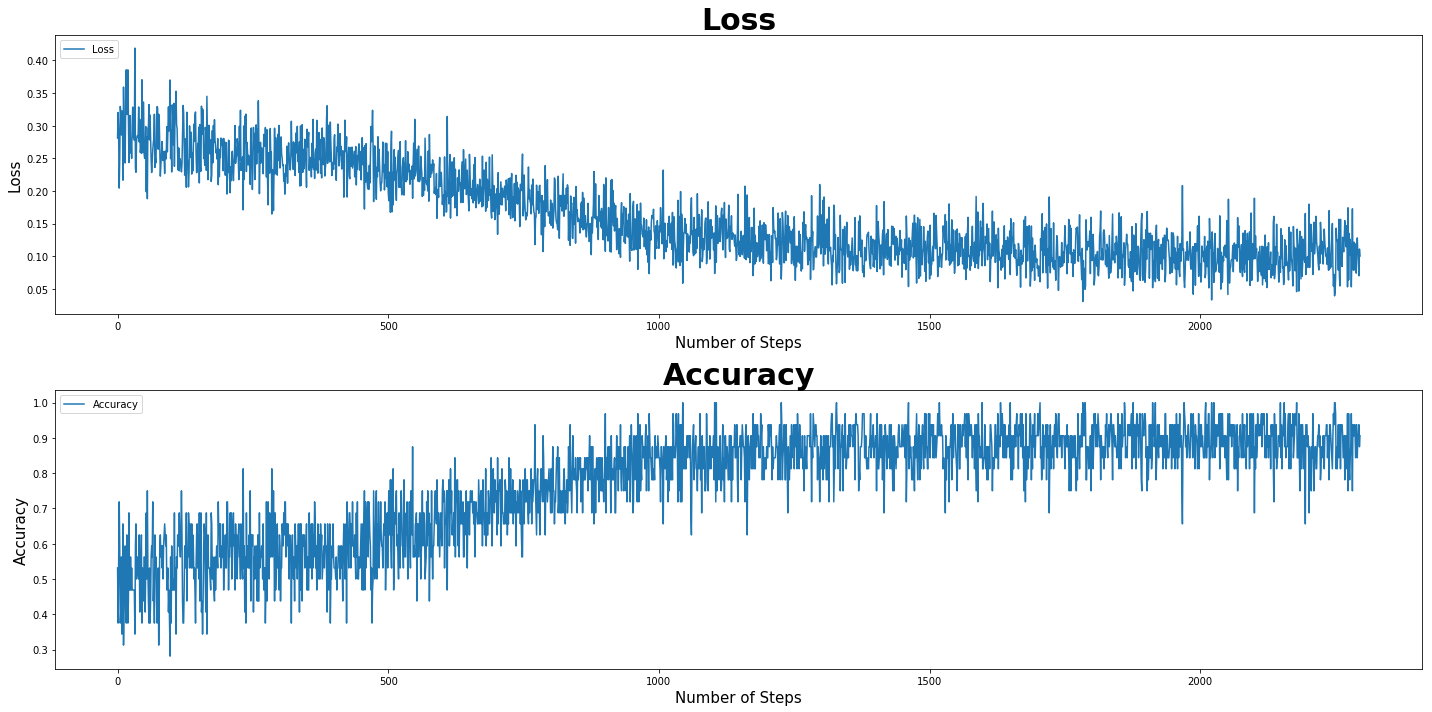

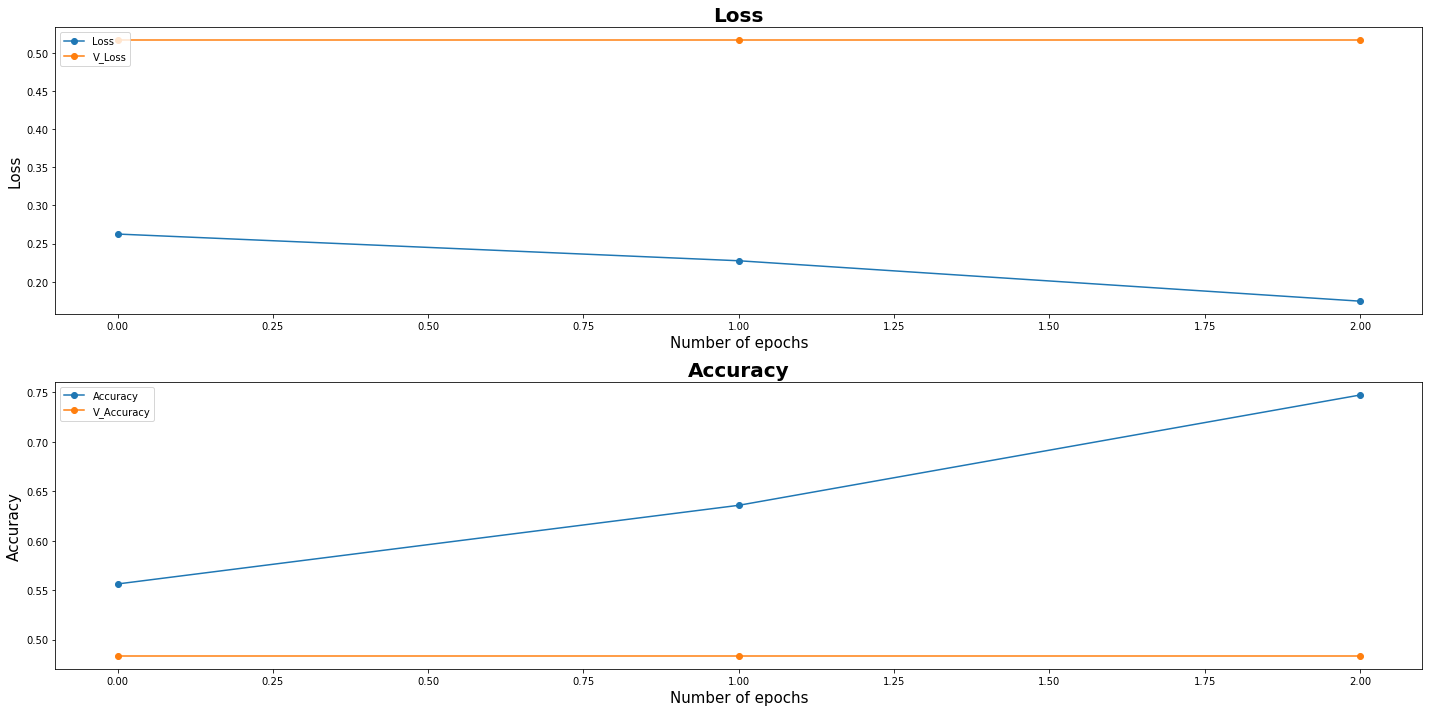

Model Saved
| Epoch [4] | Step [2297] | lr [0.000200] | Loss: [0.0947] | Acc: [0.8750] | Time: 0.0s
| Epoch [4] | Step [2298] | lr [0.000200] | Loss: [0.1182] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2299] | lr [0.000200] | Loss: [0.0647] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2300] | lr [0.000200] | Loss: [0.1393] | Acc: [0.8125] | Time: 0.0s
| Epoch [4] | Step [2301] | lr [0.000200] | Loss: [0.1172] | Acc: [0.8750] | Time: 0.0s
| Epoch [4] | Step [2302] | lr [0.000200] | Loss: [0.1264] | Acc: [0.8750] | Time: 0.0s
| Epoch [4] | Step [2303] | lr [0.000200] | Loss: [0.0707] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2304] | lr [0.000200] | Loss: [0.0999] | Acc: [0.8750] | Time: 0.0s
| Epoch [4] | Step [2305] | lr [0.000200] | Loss: [0.0866] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2306] | lr [0.000200] | Loss: [0.0852] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2307] | lr [0.000200] | Loss: [0.0827] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [

| Epoch [4] | Step [2396] | lr [0.000200] | Loss: [0.0672] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2397] | lr [0.000200] | Loss: [0.1508] | Acc: [0.7500] | Time: 0.0s
| Epoch [4] | Step [2398] | lr [0.000200] | Loss: [0.0768] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2399] | lr [0.000200] | Loss: [0.0955] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2400] | lr [0.000200] | Loss: [0.0878] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2401] | lr [0.000200] | Loss: [0.0748] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2402] | lr [0.000200] | Loss: [0.0513] | Acc: [1.0000] | Time: 0.0s
| Epoch [4] | Step [2403] | lr [0.000200] | Loss: [0.0618] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2404] | lr [0.000200] | Loss: [0.0988] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2405] | lr [0.000200] | Loss: [0.0928] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2406] | lr [0.000200] | Loss: [0.0792] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2407] | lr [

| Epoch [4] | Step [2497] | lr [0.000200] | Loss: [0.1242] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2498] | lr [0.000200] | Loss: [0.0980] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2499] | lr [0.000200] | Loss: [0.0799] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2500] | lr [0.000200] | Loss: [0.1255] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2501] | lr [0.000200] | Loss: [0.0787] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2502] | lr [0.000200] | Loss: [0.1087] | Acc: [0.8438] | Time: 0.0s
| Epoch [4] | Step [2503] | lr [0.000200] | Loss: [0.0369] | Acc: [1.0000] | Time: 0.0s
| Epoch [4] | Step [2504] | lr [0.000200] | Loss: [0.0784] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2505] | lr [0.000200] | Loss: [0.0727] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2506] | lr [0.000200] | Loss: [0.1222] | Acc: [0.8438] | Time: 0.0s
| Epoch [4] | Step [2507] | lr [0.000200] | Loss: [0.0858] | Acc: [0.9688] | Time: 0.0s
| Epoch [4] | Step [2508] | lr [

| Epoch [4] | Step [2597] | lr [0.000200] | Loss: [0.0681] | Acc: [1.0000] | Time: 0.0s
| Epoch [4] | Step [2598] | lr [0.000200] | Loss: [0.0586] | Acc: [1.0000] | Time: 0.0s
| Epoch [4] | Step [2599] | lr [0.000200] | Loss: [0.1109] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2600] | lr [0.000200] | Loss: [0.1009] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2601] | lr [0.000200] | Loss: [0.1002] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2602] | lr [0.000200] | Loss: [0.0891] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2603] | lr [0.000200] | Loss: [0.0477] | Acc: [1.0000] | Time: 0.0s
| Epoch [4] | Step [2604] | lr [0.000200] | Loss: [0.1039] | Acc: [0.9375] | Time: 0.0s
| Epoch [4] | Step [2605] | lr [0.000200] | Loss: [0.1009] | Acc: [0.9062] | Time: 0.0s
| Epoch [4] | Step [2606] | lr [0.000200] | Loss: [0.0964] | Acc: [0.8750] | Time: 0.0s
| Epoch [4] | Step [2607] | lr [0.000200] | Loss: [0.1438] | Acc: [0.8438] | Time: 0.0s
| Epoch [4] | Step [2608] | lr [

KeyboardInterrupt: 

In [897]:
while epoch < args.n_epoch:
    siamese.train()
    for i,(data, label) in enumerate(train_loader):

        
        start_t = time.time()
        data = data.to(device)
        label = label.to(device)
        siamese(data, label)
        end_t = time.time()
        all_step += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %\
              ( epoch, all_step, siamese.optim.param_groups[0]['lr'], siamese.loss.item() , siamese.acc.item() ,
                end_t - start_t))
    
    if i % 1 == 0:
        siamese.eval()
        for j, (v_data, v_label) in enumerate(valid_loader):

            start_t = time.time()
            v_data = v_data.to(device)
            v_label = v_label.to(device)
            siamese.test_step(v_data, v_label)
            end_t = time.time()
            print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %\
                  ( epoch, j, siamese.v_loss.item() , siamese.v_acc.item() ,end_t - start_t))
                
    siamese.plot_all_loss('Training_0reg')
    
    if epoch >= 1:
        plot_train_hist(train_hist, 'Epoch_0reg')

    for name in siamese.train_hist.keys():
        train_hist[name].append(sum(siamese.train_hist[name])/len(siamese.train_hist[name]))

    if not args.running_loss:
        for name in siamese.train_hist.keys():
            siamese.train_hist[name] = []
    epoch += 1
    
    if epoch % 1 == 0:
        siamese.model_save(epoch)
    
    if epoch > 5:
        raise StopIteration

In [41]:
##### This Algorithm can solve the problem and make the graph in a batch of training data #####

class Graph_Alg(object):
    
    def __init__(self,):
        self.G = nx.Graph()
    
    def forward(self, x, y):
        
        paired_data = np.array(x[y.byte()])
        for i in paired_data:
            for j in i:
                for k in range(len(j)):
                    if not j[k] in self.G.nodes:
                        self.G.add_node(j[k])
                    if k >= 1:
                        if not (j[k],j[k-1]) in self.G.edges:
                            self.G.add_edge(j[k],j[k-1])
                            
    def draw(self,):
        
        nx.draw(self.G, with_labels=True, font_weight='bold')
        plt.show()
        
    def test(self, x, y):
        
        out = []
        paired_data = np.array(x)
        
        for i in paired_data:
            out.append(self.check_step(i))
        match = list(np.array(out) == np.array(y).astype(int))
        self.acc = sum(match) / len(match)
             
    def check_step(self, i):
        
        # Check the path is in the graph
        for j in i:
            for k in range(len(j)):
                if not j[k] in self.G.nodes:
                    return 0
                if k >= 1:
                    if not (j[k],j[k-1]) in self.G.edges:
                        return 0
                        
        # Check the the pair is possible to have the same st_node   
        for node in list(self.G.adj[i[0][0].item()]):
            if node in list(self.G.adj[i[1][0].item()]):
                return 1

        return 0


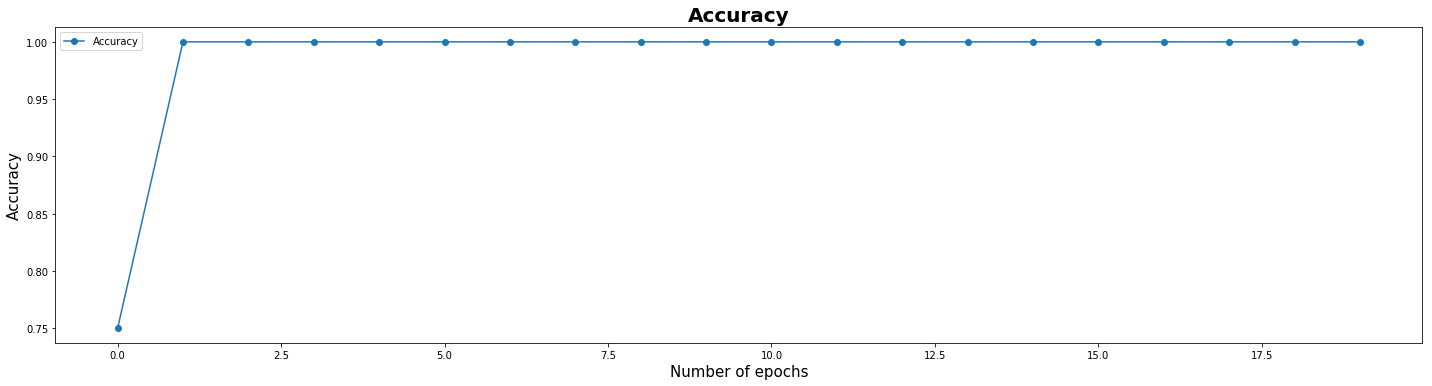

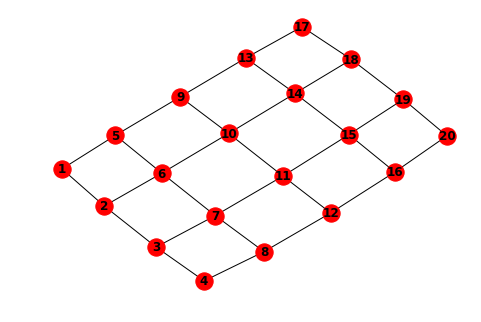

In [62]:
graph_algo = Graph_Alg()
algo_train_hist = defaultdict(list)
num_steps = 20
for i in range(num_steps):
    data, label = iter(train_loader).next()

    # Training
    graph_algo.forward(data, label)
    
    # Testing
    v_data, v_label = iter(valid_loader).next()
    graph_algo.test(v_data, v_label)
    algo_train_hist['Accuracy'].append(graph_algo.acc)
    
plot_train_hist(algo_train_hist, 'Graph_algo')
graph_algo.draw()